In [1]:
import sys
sys.path.append('./psquidpython')

In [2]:
import psquidreaders as psr
import os
from scipy.optimize import curve_fit
PSSR = psr.PSquidSweepReader
PSDR = psr.PSquidDataReader
PSRDR = psr.PSquidRawDataReader

/usr/local/lib/python2.7/site-packages/pytz/__init__.py:35: UserWarning: Module argparse was already imported from /usr/local/Cellar/python/2.7.3/Frameworks/Python.framework/Versions/2.7/lib/python2.7/argparse.pyc, but /usr/local/lib/python2.7/site-packages is being added to sys.path
  from pkg_resources import resource_stream


In [3]:
from matplotlib.pyplot import *
from numpy import *

In [4]:
%matplotlib inline

In [5]:
## Utility functions ##
#---------------------#
def shortname(fname):
    newfname = os.path.basename(fname)
    newfname = newfname.rstrip('pwrspec')
    newfname = newfname.rstrip('.')
    return newfname

def reject(fnames, rejectlist = []):
    rlist = []
    for r in rejectlist:
        for i, name in enumerate(fnames):
            if r in name:
                rlist.append(name)
    
    rlist = list(set(rlist))
        
    for rname in rlist:
        fnames.pop(fnames.index(rname))
    
    return fnames

def find_nearest(array, value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

def find_nearest_index(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx

def extract_detb(name):
    detb = name.split('DETB-')[1][:4].split('_')[0].rstrip('_abcdefghijklmnopqrstuvwxy')
    detb = float(detb)
    return detb

def extract_Tbase(fname):
    s1, _ = fname.split('mK.txt')
    Tb = s1.split('_')[-1]
    return float(Tb)/1.e3

# Conversions

In [6]:
R_para = 13.e-3  # 13 mOhm

Rsh = .85e-3  # .85 mOhm
RLDET = 200.  # 200 Ohms
RTES = 40.e-3 + R_para  # 40 mOhms (hopefully) + 13 mOhms
#RTES = 77.e-3 + R_para  # 40 mOhms (hopefully) + 13 mOhms
Rp = RTES*Rsh/(RTES + Rsh)  # R_TES || R_sh
RlineDET = 153.4  # 153.4 Ohms
V0 = 1.024
Nbits = 16

Fdet = (Rp/(Rp + RLDET + RlineDET))*V0/(2.**Nbits)  # V_TES/(DETB DAC counts)
print "F_det = V_TES/D_DETB = {0} pV/count".format(Fdet*1.e12)

F_det = V_TES/D_DETB = 36.988058893 pV/count


In [7]:
Rt = 100.  # FB Terminator = 100 Ohms
Rline = 143.5   # FB line resistance = 143.5 Ohms
V0 = 1.024   # 1.024 V is full range of DAC
RLFB = 1000.  # 1 kOhm FB load resistor
Nbits = 16   # 16 bit DAC
Rp = Rt*RLFB/(Rt + RLFB)   # Rterm || RLFB

F = Rp/(Rline + Rp)*V0/(RLFB*2.**Nbits)  # I_FB/(S1FB DAC counts)
M = 17.                                  # M = I_FB/I_TES
print "F = I_FB/D_S1FB = {0} nA/code".format(F*1.e9)
print "M = {0}".format(M)
print "F/M = I_TES/D_S!FB = {0} pA/code".format(F/M*1.e12)

F = I_FB/D_S1FB = 6.05972464611 nA/code
M = 17.0
F/M = I_TES/D_S!FB = 356.454390948 pA/code


# I-V Curve

./psquidpython/psquidreaders.py:377: FutureWarning: Numpy has detected that you (may be) writing to an array returned
by numpy.diagonal or by selecting multiple fields in a record
array. This code will likely break in the next numpy release --
see numpy.diagonal or arrays.indexing reference docs for details.
The quick fix is to make an explicit copy (e.g., do
arr.diagonal().copy() or arr[['f0','f1']].copy()).
  data[col] = data[col]/n


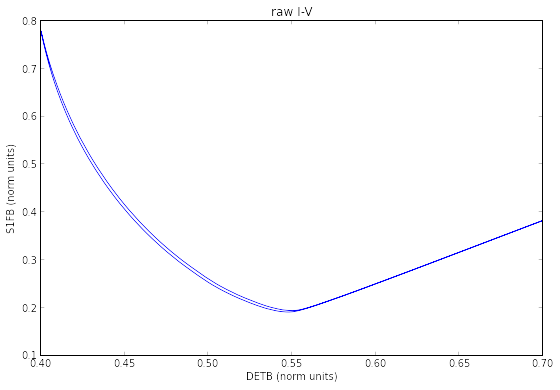

In [8]:
#basedir = '/Users/jlazear/data/noise/20140318/'
basedir = '/Users/jlazear/Documents/HDD_Documents/Data/SHINY/140301 PIPER Proposal/data/noise/20140318/'
filename = '20140318_Ch1-TES_I-V_recycled_Tbase-165mK_SHINY-shell-grounded_little-bat-floating.txt'
f = basedir + filename

pssr = PSSR(f).init_data()

detb = pssr['swept']
s1fb = pssr['locked']
fig, ax = subplots(figsize=(9, 6))

ax.plot(detb/65536, s1fb/65536.)
ax.set_xlabel('DETB (norm units)')
ax.set_ylabel('S1FB (norm units)')
ax.set_title('raw I-V')

In [9]:
detbnorm = detb[detb > .6*65536]
s1fbnorm = s1fb[detb > .6*65536]

m, b = np.polyfit(detbnorm, s1fbnorm, 1)
print "m = {0}, b = {1}".format(m, b)

detb2 = detb + 0.
s1fb2 = s1fb - b
toydets = linspace(0, max(detb2))

fig, ax = subplots(figsize=(9, 6))

ax.plot(detb2/2**16, s1fb2/2**16)
ax.plot(toydets/2**16, toydets*m/2**16, '--')
ax.set_xlabel('DETB (norm units)')
ax.set_ylabel('S1FB (norm units)')
ax.set_title('offset-removed')
ax.set_xlim(0, .72)
ax.set_ylim(0, 1.4)

m = 1.32780516148, b = -35805.8984375


(0, 1.4)

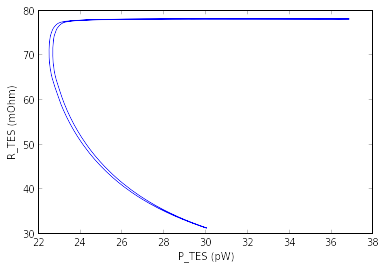

In [10]:
Vtes = Fdet*detb2
Ites = F/M*s1fb2
Rtes = Vtes/Ites
Ptes = Vtes*Ites

plot(Vtes*1.e6, Ites*1.e6)
xlabel('V_TES (uV)')
ylabel('I_TES (uA)')
figure()
plot(Ptes*1.e12, Rtes*1.e3)
xlabel('P_TES (pW)')
ylabel('R_TES (mOhm)')

# Bias Points

In [11]:
figure(figsize=(9, 6))
plot(detb/2**16, Rtes*1.e3)
xlabel('DETB (norm units)')
ylabel('R_TES (mOhm)')

DETBs = [.4, .425, .45, .475, .5, .525, .7]
DETBs_nearest = [find_nearest_index(detb, (2**16)*DETB) for DETB in DETBs]
Rs = np.array((Rtes[DETBs_nearest]).tolist())
Vs = np.array((Vtes[DETBs_nearest]).tolist())
Is = np.array((Ites[DETBs_nearest]).tolist())

pairs = zip(DETBs, Rs, Vs, Is)
pairstr = "DETB = {0:<5}  -->  R = {1:<13} mOhm, V_0 = {2:<14} uV, I_0 = {3:<13} uA"
for d, r, v, i in pairs:
        print pairstr.format(d, r*1.e3, v*1.e6, i*1.e6)

#detbdict = {DETBs[i]: {'R': Rs[i], 'V': Vs[i], 'I': Is[i]} for i in range(len(DETBs))}
detbdict = {DETBs[i]: (Rs[i], Vs[i], Is[i]) for i in range(len(DETBs))}
detbdict

DETB = 0.4    -->  R = 31.33488819   mOhm, V_0 = 0.969641973825 uV, I_0 = 30.9444840241 uA
DETB = 0.425  -->  R = 40.8211424947 mOhm, V_0 = 1.03030231458  uV, I_0 = 25.2394293057 uA
DETB = 0.45   -->  R = 49.0410141647 mOhm, V_0 = 1.09096276901  uV, I_0 = 22.2459257202 uA
DETB = 0.475  -->  R = 57.0456199348 mOhm, V_0 = 1.15162322345  uV, I_0 = 20.187759219  uA
DETB = 0.5    -->  R = 64.8987963796 mOhm, V_0 = 1.2122835642   uV, I_0 = 18.6796005437 uA
DETB = 0.525  -->  R = 72.0073953271 mOhm, V_0 = 1.27294401864  uV, I_0 = 17.6779631147 uA
DETB = 0.7    -->  R = 78.1491696835 mOhm, V_0 = 1.69682721207  uV, I_0 = 21.7126707867 uA


{0.4: (0.031334888190031052, 9.6964197382476414e-07, 3.0944484024075791e-05),
 0.425: (0.040821142494678497, 1.0303023145752377e-06, 2.5239429305656813e-05),
 0.45: (0.049041014164686203, 1.090962769012549e-06, 2.2245925720199011e-05),
 0.475: (0.057045619934797287, 1.1516232234498602e-06, 2.0187759218970314e-05),
 0.5: (0.064898796379566193, 1.2122835642003338e-06, 1.8679600543691777e-05),
 0.525: (0.072007395327091217, 1.2729440186376451e-06, 1.767796311469283e-05),
 0.7: (0.078149169683456421, 1.696827212072094e-06, 2.1712670786655508e-05)}

# Power Noise Density

In [12]:
#basedir = '/Users/jlazear/data/TES/'
basedir = r'"/Users/jlazear/Documents/HDD_Documents/Data/SHINY/140301 PIPER Proposal/data/TES/"'
txtarg = '*.txt'
txt = basedir + txtarg
fnames = !ls $txt

for fname in fnames:
    psrdr = PSRDR(fname).init_data()
    bname = os.path.basename(fname)
    length = len(psrdr)
    log2length = log2(length)
    print "{0:<10} -- {1} -- {2}".format(length, log2length, bname)

5106909    -- 22.2840189212 -- 20140318_Ch1-TES_recycled_DETB-.400_transition-state_165.0mK_SHINY-shell-grounded_little-bat-floating_i-pos300:2^10.txt
3238712    -- 21.6269887526 -- 20140318_Ch1-TES_recycled_DETB-.425_transition-state_165.0mK_SHINY-shell-grounded_little-bat-floating_i-pos300:2^10.txt
3141174    -- 21.5828724302 -- 20140318_Ch1-TES_recycled_DETB-.450_transition-state_165.0mK_SHINY-shell-grounded_little-bat-floating_i-pos300:2^10.txt
3390865    -- 21.693221917 -- 20140318_Ch1-TES_recycled_DETB-.475_transition-state_165.0mK_SHINY-shell-grounded_little-bat-floating_i-pos300:2^10.txt
3141831    -- 21.5831741491 -- 20140318_Ch1-TES_recycled_DETB-.500_transition-state_165.0mK_SHINY-shell-grounded_little-bat-floating_i-pos300:2^10.txt
3166698    -- 21.5945478571 -- 20140318_Ch1-TES_recycled_DETB-.525_transition-state_165.0mK_SHINY-shell-grounded_little-bat-floating_i-pos300:2^10.txt
838515     -- 19.6774770665 -- 20140318_Ch1-TES_recycled_DETB-.7_normal-state_quick_165.0mK_SHI

In [22]:
## Generate spectra on all new datafiles and compute I_0 ##
#---------------------------------------------------------#
#basedir = '/Users/jlazear/data/TES/'
basedir = r'"/Users/jlazear/Documents/HDD_Documents/Data/SHINY/140301 PIPER Proposal/data/TES/"'
txtarg = '*.txt'
pwrarg = '*.pwrspec'
txt = basedir + txtarg
pwr = basedir + pwrarg
!rm $pwr
fnamestxt = !ls $txt
#fnamespwr = !ls $pwr
fnamespwr = []

fnamestxt = [os.path.splitext(fname)[0] for fname in fnamestxt]
fnamespwr = [os.path.splitext(fname)[0] for fname in fnamespwr]
fnamestxt = set(fnamestxt)
fnamespwr = set(fnamespwr)

dfnames = fnamestxt - fnamespwr
fnames = ['"' + fname + '.txt"' for fname in dfnames]

toddir = '/Users/jlazear/bitbucket/tod_power/'
todfile = 'tod_power.py' 
todargs = ' -c 16 -n 300'
#todargs = ' -n 300'
todpower = toddir + todfile + todargs

for fname in fnames:
    !python $todpower $fname

rm: /Users/jlazear/Documents/HDD_Documents/Data/SHINY/140301 PIPER Proposal/data/TES/*.pwrspec: No such file or directory
{'nbins': '300', 'plotfile': None, 'title': None, 'delta_t': 0.0001, 'read_method': 'read_psquid_adc', 'window': 'hanning', 'chunklen': '16', 'pwrfile': None, 'multiplier': None, 'units': None}
0%/Users/jlazear/bitbucket/tod_power/tod_power.py:76: RuntimeWarning: invalid value encountered in divide
  binned /= counts
97%
writing to /Users/jlazear/Documents/HDD_Documents/Data/SHINY/140301 PIPER Proposal/data/TES/20140318_Ch1-TES_recycled_DETB-.425_transition-state_165.0mK_SHINY-shell-grounded_little-bat-floating_i-pos300:2^10.png /Users/jlazear/Documents/HDD_Documents/Data/SHINY/140301 PIPER Proposal/data/TES/20140318_Ch1-TES_recycled_DETB-.425_transition-state_165.0mK_SHINY-shell-grounded_little-bat-floating_i-pos300:2^10.pwrspec
{'nbins': '300', 'plotfile': None, 'title': None, 'delta_t': 0.0001, 'read_method': 'read_psquid_adc', 'window': 'hanning', 'chunklen': '1

In [13]:
import scipy.constants
kB = scipy.constants.k  # 1.3806488e-23 J/K

NEPphonon * 1.e18

NameError: name 'NEPphonon' is not defined

/Users/jlazear/Documents/HDD_Documents/Data/SHINY/140301_PIPER_Proposal/data/TES/20140318_Ch1-TES_recycled_DETB-.400_transition-state_165.0mK_SHINY-shell-grounded_little-bat-floating_i-pos300:2^10.pwrspec
/Users/jlazear/Documents/HDD_Documents/Data/SHINY/140301_PIPER_Proposal/data/TES/20140318_Ch1-TES_recycled_DETB-.425_transition-state_165.0mK_SHINY-shell-grounded_little-bat-floating_i-pos300:2^10.pwrspec
/Users/jlazear/Documents/HDD_Documents/Data/SHINY/140301_PIPER_Proposal/data/TES/20140318_Ch1-TES_recycled_DETB-.450_transition-state_165.0mK_SHINY-shell-grounded_little-bat-floating_i-pos300:2^10.pwrspec
/Users/jlazear/Documents/HDD_Documents/Data/SHINY/140301_PIPER_Proposal/data/TES/20140318_Ch1-TES_recycled_DETB-.475_transition-state_165.0mK_SHINY-shell-grounded_little-bat-floating_i-pos300:2^10.pwrspec
/Users/jlazear/Documents/HDD_Documents/Data/SHINY/140301_PIPER_Proposal/data/TES/20140318_Ch1-TES_recycled_DETB-.500_transition-state_165.0mK_SHINY-shell-grounded_little-bat-floati

(0.1, 5000.0)

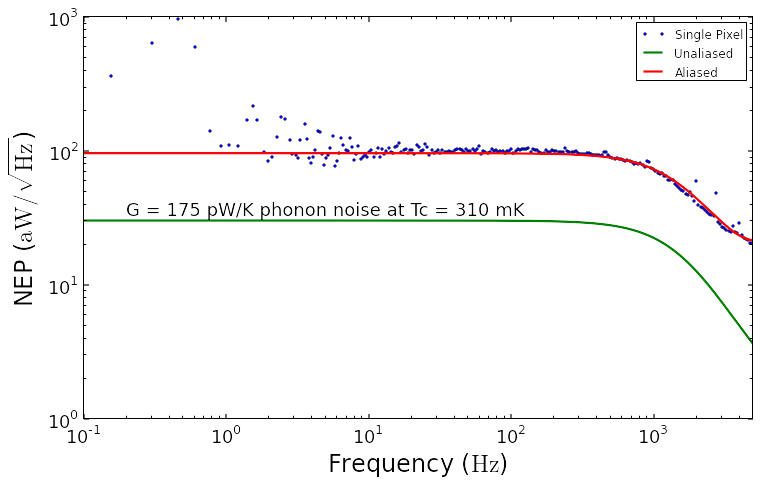

In [14]:
## Plot all spectra ##
#--------------------#
conv = F/M*(2**16)/4.096*115   # S1 DAC -> TES arm current
Rsh = .85e-3   # .85 mOhm shunt
#conv = 1.    # No conversion

#basedir = '/Users/jlazear/data/TES/'
basedir = r'/Users/jlazear/Documents/HDD_Documents/Data/SHINY/140301_PIPER_Proposal/data/TES/'
pwrarg = '*.pwrspec'
pwr = basedir + pwrarg

fnames = !ls $pwr

rejectlist = [
#              'all-unlocked', 
#              'all-unlocked_0', 
#              'all-unlocked_1', 
#              'all-unlocked_base-spectrum', 
#              'all_unlocked', 
#              'S3-locked',
#              'S2-locked',
#              'S1-locked',
#              '165.0mK',
#              'G-8',
#              'Ch6',
#              'Ch7',
              'pos100',
              'pos200',
#              'DETB-.300',
              ]
fnames = reject(fnames, rejectlist)
for fname in fnames:
    print fname

fs = []
pwrs = []
modpwrs = []
stdpwrs = []
counts = []

for fname in fnames:
    d = np.loadtxt(fname)
    d2 = d[~np.isnan(d).any(axis=1)]  # Remove rows with NaNs
    f, pwr, stdpwr, count = d2.T
    fs.append(f)
    pwrs.append(pwr)
    stdpwrs.append(stdpwrs)
    counts.append(count)
    
fig, ax = subplots(figsize=(12,7.2))

for i in range(len(fnames))[4:5]:
    fname = shortname(fnames[i])
    db = extract_detb(fname)
    r0, v0, i0 = detbdict[db]
    ItoP = i0*(r0 - Rsh)  # Essentially V = P/I. 
    print "ItoP = {0}, V0 = {1}".format(ItoP, v0) #DELME?

    pwr = pwrs[i]*conv*ItoP
    modpwrs.append(pwr)
    f = fs[i]

    label = fname.replace('SHINY-shell-grounded_little-bat-floating_', '')
    label = label.replace('20140318_', '')
    label = label.replace('recycled_', '')
    label = label.replace('DETB-', 'DETB=')
    label = label.replace('i-', 'i=')
    label = label.replace('pos', '+')
    label = label.replace(':', '/')
    label = label.replace('quick_', '')

    label = "Single Pixel"  #DELME
    ax.plot(f, pwr*1.e18, 'o', label=label, linewidth=1.5, markersize=3)
    
ax.tick_params(axis='both', labelsize=18, width=1.5, length=5)
ax.tick_params(which='minor', width=1, length=3)

yscale('log')
xscale('log')
tsize = 24
xlabel('Frequency ($\mathrm{Hz}$)', size=tsize)
#ylabel('Power Noise Density ($\mathrm{aW/\sqrt{Hz}}$)', size=tsize)
ylabel('NEP ($\mathrm{aW/\sqrt{Hz}}$)', size=tsize)

Tc = 0.310  # K
G = 175.e-12  # W/K
NEPphonon = np.sqrt(4*kB * Tc**2 * G)
#NEPphonon * 1.e18
# ax.axhline(NEPphonon * 1.e18, ls='--', color='k')
ax.text(.2, 33, 'G = 175 pW/K phonon noise at Tc = 310 mK', fontsize=18)

#ax.legend(bbox_to_anchor=(1.2, 1.2))
#ax.legend(loc='lower left')
#ylim(1.e1, 3.e3)
#savefig(basedir + '20140318_SPTD_power_noise_spectra.png', dpi=300, bbox_inches='tight')
#savefig(basedir + '20140318_SPTD_power_noise_spectra.eps', dpi=300)

#figure(figsize=np.array([12, 7.2])/1.5)
def H(ws, kappa):
    return 1./np.sqrt(1. + (ws/kappa)**2 - 2*(ws/kappa)*np.sin(2*np.pi*ws))

# ws = np.linspace(0, 0.5, 100)
#ws = np.logspace(-3, np.log10(1), 200)
ws = np.linspace(0, 1., 2000)
lo2 = len(ws)/2
ws2 = ws[:lo2]
Hs = lambda kappa: H(ws, kappa)

kappa = .06 # [.01, .03, .05, .0781, 0.2, .5, 1]
hs = Hs(kappa)
hsalias = hs[lo2:][::-1]
hs2 = hs[:lo2] + hsalias
#a = np.array([ws] + [Hs(kappa) for kappa in kappas])

k = 1.3806488e-23
fs = 10.e3
T = 0.310  # 140 mK
G = 175.e-12  # W/K
NEP = np.sqrt(4*k*G*T**2)

#i = 4
#hs = a[i]
ws_mod = np.array([1.e-1/fs] + list(ws)[1:])
ws2_mod = np.array([1.e-1/fs] + list(ws2)[1:])
hs_mod = np.array([hs[0]] + list(hs)[1:])
hs2_mod = np.array([hs2[0]] + list(hs2)[1:])
plot(ws_mod * fs, hs_mod * NEP * 1.e18, label="Unaliased", linewidth=2.5, linestyle='-')
plot(ws2_mod * fs, hs2_mod * NEP * 1.e18 * 3, label="Aliased", linewidth=2.5, linestyle='-')

legend()
# xscale('log')
# yscale('log')
xlim(1.e-1, 0.5 * 10.e3)
# ylim(10, 1000)

In [35]:
## Plot all spectra ##
#--------------------#
conv = F/M*(2**16)/4.096*115   # S1 DAC -> TES arm current
Rsh = .85e-3   # .85 mOhm shunt
#conv = 1.    # No conversion

#basedir = '/Users/jlazear/data/TES/'
basedir = r'/Users/jlazear/Documents/HDD_Documents/Data/SHINY/140301_PIPER_Proposal/data/TES/'
pwrarg = '*.pwrspec'
pwr = basedir + pwrarg

fnames = !ls $pwr

rejectlist = [
#              'all-unlocked', 
#              'all-unlocked_0', 
#              'all-unlocked_1', 
#              'all-unlocked_base-spectrum', 
#              'all_unlocked', 
#              'S3-locked',
#              'S2-locked',
#              'S1-locked',
#              '165.0mK',
#              'G-8',
#              'Ch6',
#              'Ch7',
              'pos100',
              'pos200',
#              'DETB-.300',
              ]
fnames = reject(fnames, rejectlist)
for fname in fnames:
    print fname

fs = []
pwrs = []
modpwrs = []
stdpwrs = []
counts = []

for fname in fnames:
    d = np.loadtxt(fname)
    d2 = d[~np.isnan(d).any(axis=1)]  # Remove rows with NaNs
    f, pwr, stdpwr, count = d2.T
    fs.append(f)
    pwrs.append(pwr)
    stdpwrs.append(stdpwrs)
    counts.append(count)
    
fig, ax = subplots(figsize=(12,7.2))

for i in range(len(fnames))[4:5]:
    fname = shortname(fnames[i])
    db = extract_detb(fname)
    r0, v0, i0 = detbdict[db]
    ItoP = i0*(r0 - Rsh)  # Essentially V = P/I. 
    print "ItoP = {0}, V0 = {1}".format(ItoP, v0) #DELME?

    pwr = pwrs[i]*conv*ItoP
    modpwrs.append(pwr)
    f = fs[i]

    label = fname.replace('SHINY-shell-grounded_little-bat-floating_', '')
    label = label.replace('20140318_', '')
    label = label.replace('recycled_', '')
    label = label.replace('DETB-', 'DETB=')
    label = label.replace('i-', 'i=')
    label = label.replace('pos', '+')
    label = label.replace(':', '/')
    label = label.replace('quick_', '')

    label = "Single Pixel"  #DELME
    ax.plot(f, pwr*1.e18, 'o', label=label, linewidth=5, markersize=5)
    
ax.tick_params(axis='both', labelsize=24, width=3, length=10)
ax.tick_params(which='minor', width=2, length=6)

yscale('log')
xscale('log')
tsize = 36
xlabel('Frequency ($\mathrm{Hz}$)', size=tsize)
#ylabel('Power Noise Density ($\mathrm{aW/\sqrt{Hz}}$)', size=tsize)
ylabel('NEP ($\mathrm{aW/\sqrt{Hz}}$)', size=tsize)

Tc = 0.310  # K
G = 175.e-12  # W/K
NEPphonon = np.sqrt(4*kB * Tc**2 * G)
#NEPphonon * 1.e18
# ax.axhline(NEPphonon * 1.e18, ls='--', color='k')
ax.text(.2, 15, 'G = 175 pW/K phonon noise at Tc = 310 mK', fontsize=24)

#ax.legend(bbox_to_anchor=(1.2, 1.2))
#ax.legend(loc='lower left')
#ylim(1.e1, 3.e3)
#savefig(basedir + '20140318_SPTD_power_noise_spectra.png', dpi=300, bbox_inches='tight')
#savefig(basedir + '20140318_SPTD_power_noise_spectra.eps', dpi=300)

#figure(figsize=np.array([12, 7.2])/1.5)
def H(ws, kappa):
    return 1./np.sqrt(1. + (ws/kappa)**2 - 2*(ws/kappa)*np.sin(2*np.pi*ws))

# ws = np.linspace(0, 0.5, 100)
#ws = np.logspace(-3, np.log10(1), 200)
ws = np.linspace(0, 1., 2000)
lo2 = len(ws)/2
ws2 = ws[:lo2]
Hs = lambda kappa: H(ws, kappa)

kappa = .06 # [.01, .03, .05, .0781, 0.2, .5, 1]
hs = Hs(kappa)
hsalias = hs[lo2:][::-1]
hs2 = hs[:lo2] + hsalias
#a = np.array([ws] + [Hs(kappa) for kappa in kappas])

k = 1.3806488e-23
fs = 10.e3
T = 0.310  # 140 mK
G = 175.e-12  # W/K
NEP = np.sqrt(4*k*G*T**2)

#i = 4
#hs = a[i]
ws_mod = np.array([1.e-1/fs] + list(ws)[1:])
ws2_mod = np.array([1.e-1/fs] + list(ws2)[1:])
hs_mod = np.array([hs[0]] + list(hs)[1:])
hs2_mod = np.array([hs2[0]] + list(hs2)[1:])
plot(ws_mod * fs, hs_mod * NEP * 1.e18, label="Unaliased", linewidth=5, linestyle='-')
plot(ws2_mod * fs, hs2_mod * NEP * 1.e18 * 3, label="Aliased", linewidth=5, linestyle='-')

legend(loc='lower left', fontsize=24)
# xscale('log')
# yscale('log')
xlim(1.e-1, 0.5 * 10.e3)
# ylim(10, 1000)
[s.set_linewidth(3) for s in ax.spines.itervalues()]
savedir = '/Users/jlazear/Documents/HDD Documents/Talks and Presentations/Thesis Defense/imgs/'
fig.savefig(savedir + 'single_pixel_power_spectrum.png', dpi=200, bbox_inches='tight')

/Users/jlazear/Documents/HDD_Documents/Data/SHINY/140301_PIPER_Proposal/data/TES/20140318_Ch1-TES_recycled_DETB-.400_transition-state_165.0mK_SHINY-shell-grounded_little-bat-floating_i-pos300:2^10.pwrspec
/Users/jlazear/Documents/HDD_Documents/Data/SHINY/140301_PIPER_Proposal/data/TES/20140318_Ch1-TES_recycled_DETB-.425_transition-state_165.0mK_SHINY-shell-grounded_little-bat-floating_i-pos300:2^10.pwrspec
/Users/jlazear/Documents/HDD_Documents/Data/SHINY/140301_PIPER_Proposal/data/TES/20140318_Ch1-TES_recycled_DETB-.450_transition-state_165.0mK_SHINY-shell-grounded_little-bat-floating_i-pos300:2^10.pwrspec
/Users/jlazear/Documents/HDD_Documents/Data/SHINY/140301_PIPER_Proposal/data/TES/20140318_Ch1-TES_recycled_DETB-.475_transition-state_165.0mK_SHINY-shell-grounded_little-bat-floating_i-pos300:2^10.pwrspec
/Users/jlazear/Documents/HDD_Documents/Data/SHINY/140301_PIPER_Proposal/data/TES/20140318_Ch1-TES_recycled_DETB-.500_transition-state_165.0mK_SHINY-shell-grounded_little-bat-floati

In [549]:
ws_mod

array([  1.00000000e-05,   0.00000000e+00,   5.00250125e-04, ...,
         9.98999500e-01,   9.99499750e-01,   1.00000000e+00])

In [37]:
def H(ws, kappa):
    return 1./np.sqrt(1. + (ws/kappa)**2 - 2*(ws/kappa)*np.sin(2*np.pi*ws))

# ws = np.linspace(0, 0.5, 100)
#ws = np.logspace(-3, np.log10(1), 200)
ws = np.linspace(0, 1., 2000)
lo2 = len(ws)/2
ws2 = ws[:lo2]
Hs = lambda kappa: H(ws, kappa)

kappa = .06 # [.01, .03, .05, .0781, 0.2, .5, 1]
hs = Hs(kappa)
hsalias = hs[lo2:][::-1]
hs2 = hs[:lo2] + hsalias
#a = np.array([ws] + [Hs(kappa) for kappa in kappas])

k = 1.3806488e-23
fs = 10.e3
T = 0.310  # 140 mK
G = 175.e-12  # W/K
NEP = np.sqrt(4*k*G*T**2)

#i = 4
#hs = a[i]
plot(ws * fs, hs * NEP * 1.e18, label="Unaliased")
plot(ws2 * fs, hs2 * NEP * 1.e18 * 3, label="Aliased")

xscale('log')
xlim(xmax=5.e3)

(1.0, 5000.0)

# G and T_c

In [38]:
basedir = r'/Users/jlazear/Documents/HDD_Documents/Data/SHINY/140301_PIPER_Proposal/data/G/'
fnamesext = '2014*I-V*.txt'
lsfnames = basedir + fnamesext

#fnamesiv = !ls /Users/jlazear/data/G/2014*I-V*.txt
fnamesiv = !ls $lsfnames
for fname in fnamesiv:
    print fname

/Users/jlazear/Documents/HDD_Documents/Data/SHINY/140301_PIPER_Proposal/data/G/20140312_Ch1-I-V_S1-locked_transition_265mK.txt
/Users/jlazear/Documents/HDD_Documents/Data/SHINY/140301_PIPER_Proposal/data/G/20140312_Ch1-I-V_S1-locked_transition_270mK.txt
/Users/jlazear/Documents/HDD_Documents/Data/SHINY/140301_PIPER_Proposal/data/G/20140312_Ch1-I-V_S1-locked_transition_275mK.txt
/Users/jlazear/Documents/HDD_Documents/Data/SHINY/140301_PIPER_Proposal/data/G/20140312_Ch1-I-V_S1-locked_transition_280mK.txt
/Users/jlazear/Documents/HDD_Documents/Data/SHINY/140301_PIPER_Proposal/data/G/20140312_Ch1-I-V_S1-locked_transition_285mK.txt
/Users/jlazear/Documents/HDD_Documents/Data/SHINY/140301_PIPER_Proposal/data/G/20140312_Ch1-I-V_S1-locked_transition_290mK.txt
/Users/jlazear/Documents/HDD_Documents/Data/SHINY/140301_PIPER_Proposal/data/G/20140312_Ch1-I-V_S1-locked_transition_295mK.txt
/Users/jlazear/Documents/HDD_Documents/Data/SHINY/140301_PIPER_Proposal/data/G/20140312_Ch1-I-V_S1-locked_trans

In [39]:
ivscript = '/Users/jlazear/bitbucket/piper_mce_script/python/iv_analysis_labtest.py'
cfgfile = '/Users/jlazear/bitbucket/piper_mce_script/template/shiny.cfg'
for fname in fnamesiv:
    !python $ivscript $fname $cfgfile

Failed to load PDF collation libraries.
/Users/jlazear/bitbucket/piper_mce_script/python/psquidreaders.py:377: FutureWarning: Numpy has detected that you (may be) writing to an array returned
by numpy.diagonal or by selecting multiple fields in a record
array. This code will likely break in the next numpy release --
see numpy.diagonal or arrays.indexing reference docs for details.
The quick fix is to make an explicit copy (e.g., do
arr.diagonal().copy() or arr[['f0','f1']].copy()).
  data[col] = data[col]/n
loading hdf5 IV file
span =  5
trans_begin =  226
trans_begin =  226
trans_bias =  0.381328
det =  {'super_idx1': 446, 'super_idx0': 346, 'norm_offset': -0.15777241797944186, 'ok': True, 'Rsuper': 2.9462177692138192, 'norm_idx1': 216, 'norm_idx0': 0, 'Rnorm': 0.51245946639412954, 'super_offset': -0.40477903931981951, 'trans_bias': 0.38132814, 'trans_begin': 226, 'trans_end': 346}
==========FILE = /Users/jlazear/Documents/HDD_Documents/Data/SHINY/140301_PIPER_Proposal/data/G/20140312

In [45]:
Tbases = [extract_Tbase(fname) for fname in fnamesiv]

basedir = r'/Users/jlazear/Documents/HDD_Documents/Data/SHINY/140301_PIPER_Proposal/data/'
ivnames = 'G/20140312*.ivout'
ivout = basedir + ivnames
#ivoutfiles = !ls ~/data/G/20140312*.ivout
ivoutfiles = !ls $ivout

Is = []
Vs = []
Vs2 = []
Ps = []
Ps2 = []
Rs = []
Rs2 = []
for fname in ivoutfiles:
    I, V, P = np.loadtxt(fname).T
    R = V/I
    nmin = diff(R).argmin() + 10
    try:
        rp = R[nmin:].min()
        V2 = V - I*rp
    except ValueError:
        continue
    R2 = V2/I
    P2 = I*V2
    Is.append(I)
    Vs.append(V)
    Ps.append(P)   
    Rs.append(R)
    Rs2.append(R2)
    Vs2.append(V2)
    Ps2.append(P2)

In [46]:
basedir = r'/Users/jlazear/Documents/HDD_Documents/Data/SHINY/140301_PIPER_Proposal/data/TES/'
#basedir = '/Users/jlazear/data/TES/'

fig, ax = subplots(figsize=(12, 7.2))
rejectlist = [.3065, .3055, .3045, .3035, 
              .3025, .3015, .3005, .299, .275]

Tc = .309

for i in range(len(Tbases)):
    Tbase = Tbases[i]
    if Tbase in rejectlist: continue
    I = Is[i]
    V = Vs[i]
    label = 'Tbase = {0} mK'.format(Tbase*1.e3)
#     label = '$\Delta$T = {0} mK'.format((Tc - Tbase)*1.e3)
    l, = ax.plot(V, I, '-', label=label, linewidth=2)
    c = l.get_color()
    ax.plot(V, I, 'o', markerfacecolor='none', markeredgecolor=c, markersize=5)


legend(loc='upper right', fontsize=16)

ax.tick_params(axis='both', labelsize=18)
ax.set_ylim(bottom=0)
ax.set_xlim(right=1.2)

tsize = 24
xlabel('Uncorrected V_TES ($\mathrm{\mu V}$)', fontsize=20)
ylabel('I_TES ($\mathrm{\mu A}$)', fontsize=20)
#title('Family of I-V curves for SPTD\n2014-03-12')

savefig(basedir + 'SPTD_I-V.png', dpi=300, bbox_inches='tight')
#savefig(basedir + 'SPTD_I-V.eps', dpi=300)

In [44]:
basedir = r'/Users/jlazear/Documents/HDD_Documents/Data/SHINY/140301_PIPER_Proposal/data/TES/'
#basedir = '/Users/jlazear/data/TES/'

fig, ax = subplots(figsize=(12, 7.2))
rejectlist = [.3065, .3055, .3045, .3035, 
              .3025, .3015, .3005, .299, .275]

Tc = .309

for i in range(len(Tbases)):
    Tbase = Tbases[i]
    if Tbase in rejectlist: continue
    I = Is[i]
    V2 = Vs2[i]
    label = 'Tbase = {0} mK'.format(Tbase*1.e3)
#     label = '$\Delta$T = {0} mK'.format((Tc - Tbase)*1.e3)
    l, = ax.plot(V2, I, label=label, linewidth=2)
    c = l.get_color()
    ax.plot(V2, I, 'o', markerfacecolor='none', markeredgecolor=c, markersize=5)

legend(loc='upper right', fontsize=20)

ax.tick_params(axis='both', labelsize=18)
ax.set_ylim(bottom=0)
ax.set_xlim(right=1.2)

tsize = 20
xlabel('V_TES ($\mathrm{\mu V}$)', size=tsize)
ylabel('I_TES ($\mathrm{\mu A}$)', size=tsize)
#title('Family of I-V curves for SPTD\n2014-03-12')

savefig(basedir + 'SPTD_I-V2.png', dpi=300, bbox_inches='tight')
#savefig(basedir + 'SPTD_I-V.eps', dpi=300)

NameError: name 'ls' is not defined

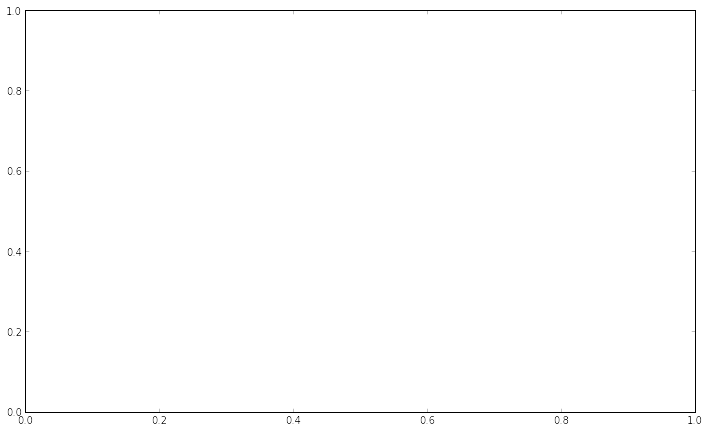

In [42]:
savedir = '/Users/jlazear/Documents/HDD Documents/Talks and Presentations/Thesis Defense/imgs/'
basedir = r'/Users/jlazear/Documents/HDD_Documents/Data/SHINY/140301_PIPER_Proposal/data/TES/'
#basedir = '/Users/jlazear/data/TES/'

fig, ax = subplots(figsize=(12, 7.2))
rejectlist = [.3065, .3055, .3045, .3035, 
              .3025, .3015, .3005, .299, .275]

Tc = .309

for i in range(len(Tbases)):
    Tbase = Tbases[i]
    if Tbase in rejectlist: continue
    I = Is[i]
    V2 = Vs2[i]
    label = 'Tbase = {0} mK'.format(Tbase*1.e3)
#     label = '$\Delta$T = {0} mK'.format((Tc - Tbase)*1.e3)
    l, = ax.plot(V2, I, ls, label=label, linewidth=2.5)
    c = l.get_color()
    ax.plot(V2, I, 'o', markerfacecolor='none', markeredgecolor=c, markersize=5)

legend(loc='upper right', fontsize=22)

ax.tick_params(axis='both', labelsize=24)
ax.set_ylim(bottom=0)
ax.set_xlim(right=1.2)

tsize = 36
xlabel('V_TES ($\mathrm{\mu V}$)', size=tsize)
ylabel('I_TES ($\mathrm{\mu A}$)', size=tsize)
#title('Family of I-V curves for SPTD\n2014-03-12')

[s.set_linewidth(3) for s in ax.spines.itervalues()]
#savefig(savedir + 'SPTD_I-V3.png', dpi=300, bbox_inches='tight')
#savefig(basedir + 'SPTD_I-V.eps', dpi=300)

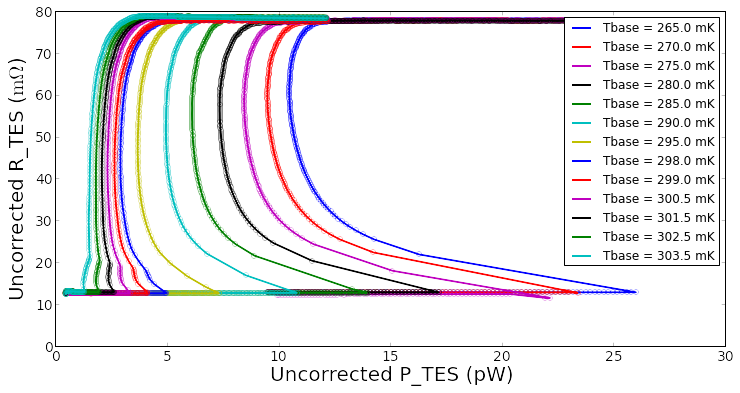

In [179]:
# basedir = '/Users/jlazear/data/TES/'
basedir = r'/Users/jlazear/Documents/HDD_Documents/Data/SHINY/140301_PIPER_Proposal/data/TES/'

fig, ax = subplots(figsize=(12, 6))
rejectlist = [.3065, .3055, .3045,]# .3035, .265, .270, .275, .280, .285, .290, .295]

i_mids = []
index_mids = []
Tbase_mids = []
P_mids = []
R_mids = []
Rmid = mean(Rs[7][:50])/2
for i in range(len(Tbases)):
    Tbase = Tbases[i]
    if Tbase in rejectlist: continue
    P = Ps[i]
    R = Rs[i]
    label = 'Tbase = {0} mK'.format(Tbase*1.e3)
    l, = ax.plot(P, R*1.e3, label=label, linewidth=2)
    c = l.get_color()
    ax.plot(P, R*1.e3, 'o', markerfacecolor='none', markeredgecolor=c, markersize=5)
    
    nindex = find_nearest_index(R, Rmid)
    pmid = P[nindex]
    rmid = R[nindex]
    
    i_mids.append(i)
    index_mids.append(nindex)
    Tbase_mids.append(Tbase)
    P_mids.append(pmid)
    R_mids.append(rmid)
    
ax.tick_params(axis='both', labelsize=14)
xlabel('Uncorrected P_TES (pW)', fontsize=20)
ylabel('Uncorrected R_TES ($\mathrm{m\Omega}$)', fontsize=20)
# title('Family of R-P curves for SPTD\n2014-03-12', fontsize=20)
ylim(0, .08*1.e3)
leg = legend(loc='upper right')
leg.get_frame().set_facecolor('white')

savefig(basedir + 'SPTD_R-P.png', dpi=300, bbox_inches='tight')

In [235]:
from scipy.interpolate import interp1d
from scipy.signal import decimate
from scipy.stats import binned_statistic

In [270]:
pgrid[:-1], p3

(array([  0.        ,   0.46542956,   0.93085912,   1.39628867,
          1.86171823,   2.32714779,   2.79257735,   3.25800691,
          3.72343647,   4.18886602,   4.65429558,   5.11972514,
          5.5851547 ,   6.05058426,   6.51601382,   6.98144337,
          7.44687293,   7.91230249,   8.37773205,   8.84316161,
          9.30859117,   9.77402072,  10.23945028,  10.70487984,
         11.1703094 ,  11.63573896,  12.10116851,  12.56659807,
         13.03202763,  13.49745719,  13.96288675,  14.42831631,
         14.89374586,  15.35917542,  15.82460498,  16.29003454,
         16.7554641 ,  17.22089366,  17.68632321,  18.15175277,
         18.61718233,  19.08261189,  19.54804145,  20.01347101,
         20.47890056,  20.94433012,  21.40975968,  21.87518924,  22.3406188 ]),
 array([  0.        ,   6.98846247,   7.63407822,   8.27969397,
          8.92530972,   9.57092547,  10.21654122,  10.86215697,
         11.50777272,  12.15338847,  12.79900422,  13.44461998,
         14.09023573,  1

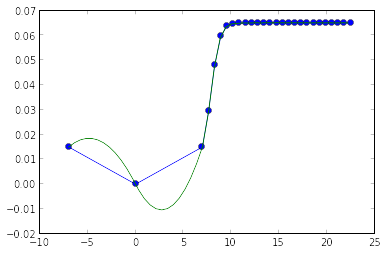

In [297]:
i = 0
p = Ps2[i]
r = Rs2[i]
p2 = p[p > 5]
r2 = r[p > 5]

r3, r_edges, r_num = binned_statistic(p2, r2, bins=25)
p3 = 0.5*(r_edges[:-1] + r_edges[1:])
p3 = np.insert(p3, 0, [-p3[0], 0])
r3 = np.insert(r3, 0, [r3[0],  0])

# plot(p2, r2)
plot(p3, r3, '-o')

ifunc3 = interp1d(p3, r3, kind='quadratic')
pgrid = np.linspace(p3.min(), p.max())[:-1]
rgrid = ifunc3(pgrid)
plot(pgrid, rgrid)

# plot(p2, r2, 'x')
# plot(p3, r3, 'o')

# p2 = np.append(p2, 0)
# r2 = np.append(r2, 0)
# ifunc2 = interp1d(p2[::-1], r2[::-1], kind='cubic')
# pgrid = np.linspace(p2.min(), p2.max())
# rgrid = ifunc2(pgrid)
# plot(p2, r2, 'o')
# plot(pgrid, rgrid)

In [315]:
ifunc3(p3[0])

array(0.01500064584124533)

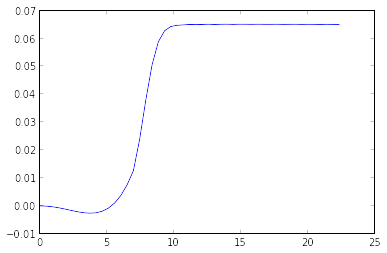

In [324]:
i = 0
p = Ps2[i]
r = Rs2[i]
p2 = p[p > 2.5][::-1]
r2 = r[p > 2.5][::-1]
r3, r_edges, r_num = binned_statistic(p2, r2, bins=25)
p3 = 0.5*(r_edges[:-1] + r_edges[1:])

ifunc3 = interp1d(p3, r3, kind='quadratic')
x0 = p2[0]
r0 = r2[0]
d0 = (r2[1] - r2[0])/(p2[1] - p2[0])
# alpha = r2[0]/(p2[0]**2)
alpha = (d0 - 2*r0/x0)/(2*x0**3)
beta = -(d0 - 4*r0/x0)/(2*x0)
# lowifunc = lambda p: alpha*p**2
lowifunc = lambda p: alpha*p**4 + beta*p**2
pgrid = np.linspace(p.min(), p.max())[:-1]

rgrid = []
for p in pgrid:
    rval = lowifunc(p) if (p < p3[0]) else ifunc3(p)
    rgrid.append(rval)
rgrid = np.array(rgrid)
    
# newifunc = lambda p: lowifunc(p) if (p < p3[0]) else ifunc3(p)

# print pgrid
# rgrid = np.array([newifunc(pg) for pg in pgrid])
plot(pgrid, rgrid)

In [325]:
alpha, beta

(1.2830931098425968e-05, -0.00036632241417817351)

In [188]:
i = 2
p = Ps2[i]
r = Rs2[i]
ifunc = interp1d(p, r, kind='cubic')
Psgrid = np.linspace(Ps2[i].min(), Ps2[i].max(), 200)
plot(Psgrid, ifunc(Psgrid))

(0, 15)

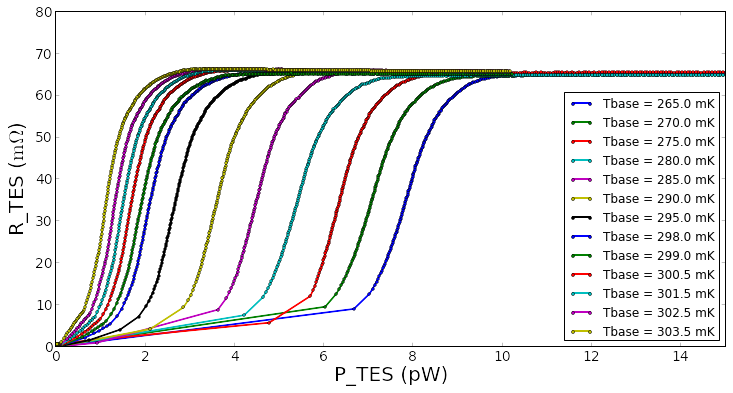

In [212]:
# basedir = '/Users/jlazear/data/TES/'
basedir = r'/Users/jlazear/Documents/HDD_Documents/Data/SHINY/140301_PIPER_Proposal/data/TES/'

fig, ax = subplots(figsize=(12, 6))
rejectlist = [.3065, .3055, .3045,]# .3035, .265, .270, .275, .280, .285, .290, .295]

i_mids = []
index_mids = []
Tbase_mids = []
P_mids = []
R_mids = []
Rmid = mean(Rs2[7][:50])/2
for i in range(len(Tbases)):
    Tbase = Tbases[i]
    if Tbase in rejectlist: continue
    P = Ps2[i]
    R = Rs2[i]
    label = 'Tbase = {0} mK'.format(Tbase*1.e3)
    l, = ax.plot(P, R*1.e3, '-o', label=label, linewidth=2, markersize=3)
#     c = l.get_color()
#     ax.plot(P, R*1.e3, 'o', markerfacecolor='none', markeredgecolor=c, markersize=5)

    
    nindex = find_nearest_index(R, Rmid)
    pmid = P[nindex]
    rmid = R[nindex]
    
    i_mids.append(i)
    index_mids.append(nindex)
    Tbase_mids.append(Tbase)
    P_mids.append(pmid)
    R_mids.append(rmid)
    
ax.tick_params(axis='both', labelsize=14)
leg = legend(loc='lower right')
leg.get_frame().set_facecolor('white')
xlabel('P_TES (pW)', fontsize=20)
ylabel('R_TES ($\mathrm{m\Omega}$)', fontsize=20)
# title('Family of I-V curves for SPTD\n2014-03-12')
ylim(0, .08*1.e3)
xlim(0, 15)

#savefig(basedir + 'SPTD_R-P2.png', dpi=300, bbox_inches='tight')

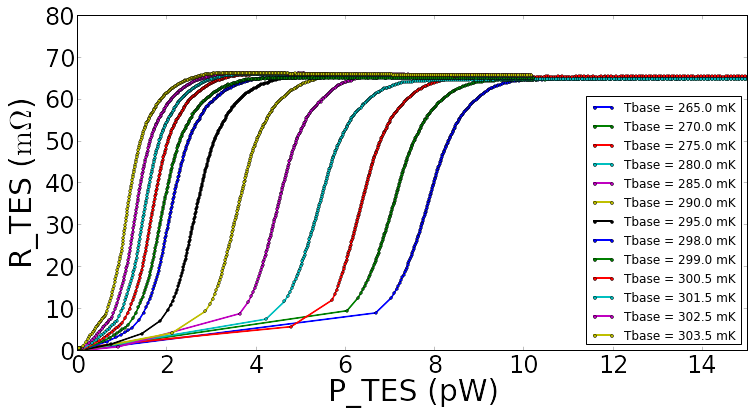

In [577]:
# basedir = '/Users/jlazear/data/TES/'
basedir = r'/Users/jlazear/Documents/HDD_Documents/Data/SHINY/140301_PIPER_Proposal/data/TES/'

fig, ax = subplots(figsize=(12, 6))
rejectlist = [.3065, .3055, .3045,]# .3035, .265, .270, .275, .280, .285, .290, .295]

i_mids = []
index_mids = []
Tbase_mids = []
P_mids = []
R_mids = []
Rmid = mean(Rs2[7][:50])/2
for i in range(len(Tbases)):
    Tbase = Tbases[i]
    if Tbase in rejectlist: continue
    P = Ps2[i]
    R = Rs2[i]
    label = 'Tbase = {0} mK'.format(Tbase*1.e3)
    l, = ax.plot(P, R*1.e3, '-o', label=label, linewidth=2, markersize=3)
#     c = l.get_color()
#     ax.plot(P, R*1.e3, 'o', markerfacecolor='none', markeredgecolor=c, markersize=5)

    
    nindex = find_nearest_index(R, Rmid)
    pmid = P[nindex]
    rmid = R[nindex]
    
    i_mids.append(i)
    index_mids.append(nindex)
    Tbase_mids.append(Tbase)
    P_mids.append(pmid)
    R_mids.append(rmid)
    
ax.tick_params(axis='both', labelsize=24)
leg = legend(loc='lower right', fontsize=12)
leg.get_frame().set_facecolor('white')
xlabel('P_TES (pW)', fontsize=30)
ylabel('R_TES ($\mathrm{m\Omega}$)', fontsize=30)
# title('Family of I-V curves for SPTD\n2014-03-12')
ylim(0, .08*1.e3)
xlim(0, 15)

savefig(basedir + 'SPTD_R-P3.png', dpi=300, bbox_inches='tight')

G = 220.74 pW/K, T_c = 308.09 mK, K = 7547.91 pW/K^beta, beta = n - 1 = 3.00
[[  6.63753345e-05   8.17321483e-05]
 [  8.17321483e-05   1.03485230e-04]]


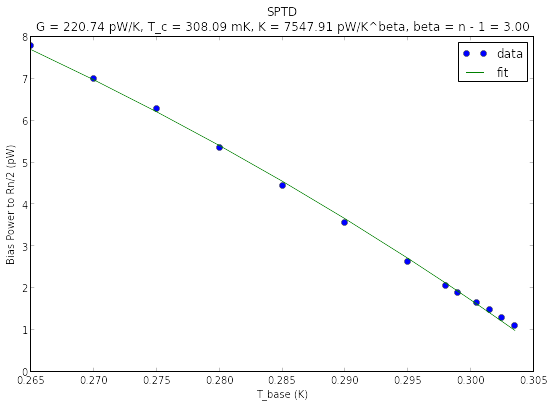

In [328]:
#basedir = '/Users/jlazear/data/TES/'

def fitfunc(T, A, B):
    return A - B*T**4

Tbase_mids = np.array(Tbase_mids)
P_mids = np.array(P_mids)

fig, ax = subplots(figsize=(9, 6))
ax.plot(Tbase_mids, P_mids, 'o', label='data')

popt, pcov = curve_fit(fitfunc, Tbase_mids, P_mids, p0=(4.5, 540.))
#m2, m, b = np.polyfit(Tbase_mids, P_mids, 2)

ax.plot(Tbase_mids, fitfunc(Tbase_mids, *popt), label='fit')
legend(loc='upper right')
ax.set_xlabel('T_base (K)')
ax.set_ylabel('Bias Power to Rn/2 (pW)')

gamma = 4.
A, B = popt
rel = np.outer(popt, popt)

beta = gamma - 1
K = B*gamma
Tc = (A/B)**(1/gamma)
G = K*(Tc**beta)

lblstr = "G = {0:.2f} pW/K, T_c = {1:.2f} mK, K = {2:.2f} pW/K^beta, beta = n - 1 = {3:.2f}".format(G, Tc*1.e3, K, beta)
ax.set_title('SPTD\n' + lblstr)
print lblstr
print pcov/rel

fig.savefig(basedir + 'G_Tc_power_beta-fixed.png', dpi=200)

G = 195.61 pW/K, T_c = 309.01 mK, K = 898.84 pW/K^beta, beta = n - 1 = 1.30
[[ 0.01560667 -0.03515158 -0.01873415]
 [-0.03515158  0.07946216  0.04229762]
 [-0.01873415  0.04229762  0.02252435]]


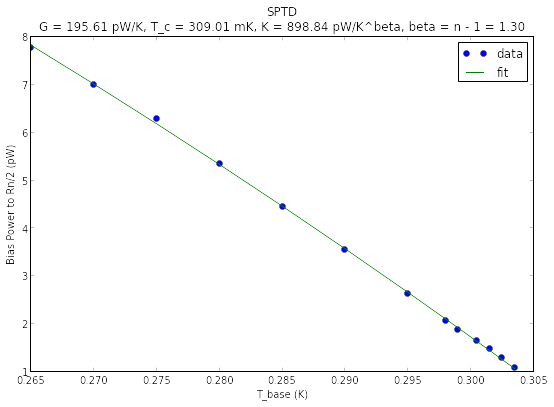

In [495]:
#basedir = '/Users/jlazear/data/TES/'

def fitfunc(T, A, B, gamma):
    return A - B*T**gamma

Tbase_mids = np.array(Tbase_mids)
P_mids = np.array(P_mids)

fig, ax = subplots(figsize=(9, 6))
ax.plot(Tbase_mids, P_mids, 'o', label='data')

popt, pcov = curve_fit(fitfunc, Tbase_mids, P_mids, p0=(4.5, 540., 4.))
#m2, m, b = np.polyfit(Tbase_mids, P_mids, 2)

ax.plot(Tbase_mids, fitfunc(Tbase_mids, *popt), label='fit')
legend(loc='upper right')
ax.set_xlabel('T_base (K)')
ax.set_ylabel('Bias Power to Rn/2 (pW)')

A, B, gamma = popt
rel = np.outer(popt, popt)

beta = gamma - 1
K = B*gamma
Tc = (A/B)**(1/gamma)
G = K*(Tc**beta)

lblstr = "G = {0:.2f} pW/K, T_c = {1:.2f} mK, K = {2:.2f} pW/K^beta, beta = n - 1 = {3:.2f}".format(G, Tc*1.e3, K, beta)
ax.set_title('SPTD\n' + lblstr)
print lblstr
print pcov/rel

#fig.savefig(basedir + 'G_Tc_power.png', dpi=200)

In [496]:
from scipy.stats import chi2

dPdT = K * Tbase_mids ** beta
dT = 1.e-3
sP_mids = dPdT * dT
f = lambda T: fitfunc(T, *popt)
eys = f(Tbase_mids)

def chi2value(xs, ys, sys, fitfunc):
    eys = fitfunc(xs)
    return np.sum(((ys - eys)/sys)**2)

x2power = chi2value(Tbase_mids, P_mids, sP_mids, f)
dof = len(Tbase_mids) - 1
print "x2/({0} - 1) = ".format(dof), x2power/(dof - 1)
print chi2.cdf(x2power, dof - 1)

x2/(12 - 1) =  0.0664796596673
1.00858618595e-05


G = 175 pW/K
T_c = 310 mK
G = 176.597827785 +- 2.8251837922 pW/K
Tc = 309.852662107 +- 5.13606589105 mK


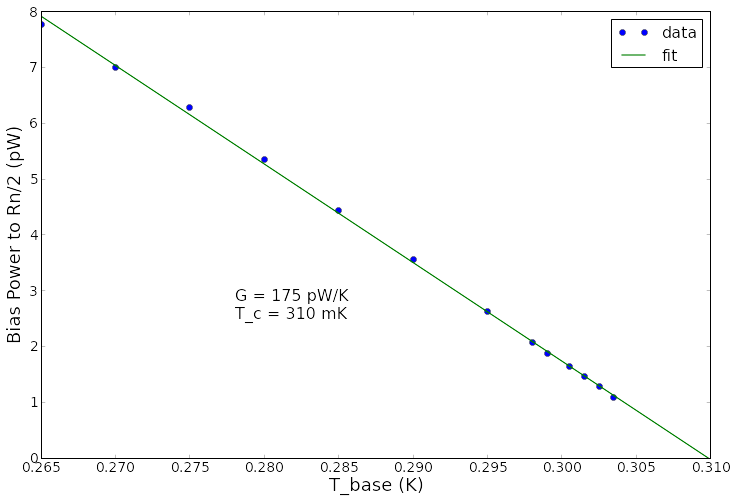

In [503]:
#basedir = '/Users/jlazear/data/TES/'

Tbase_mids = np.array(Tbase_mids)
P_mids = np.array(P_mids)

fig, ax = subplots(figsize=(12, 8))
ax.plot(Tbase_mids, P_mids, 'o', label='data')

(m, b), cov = np.polyfit(Tbase_mids, P_mids, 1, cov=True)

T0s = np.linspace(0.265, .310)
P0s = m*T0s + b
# ax.plot(Tbase_mids, m*Tbase_mids + b, label='fit', linewidth=1.5)
ax.plot(T0s, P0s, label='fit', linewidth=1.5)
legend(loc='upper right', fontsize=16)
ax.set_xlabel('T_base (K)', fontsize=18)
ax.set_ylabel('Bias Power to Rn/2 (pW)', fontsize=18)
ax.tick_params(axis='both', labelsize=14)

ax.set_xlim(.265, .310)
ax.set_ylim(0, 8)

G = -m  # pW/K, since P_mids is in pW
sG = cov[0, 0]
sb = cov[1, 1]
Tc = b/G  # K, since b is in pW
sTc = Tc*np.sqrt((sb/b)**2 + (sG/G)**2)

lblstr = "G = {0} pW/K\nT_c = {1} mK".format(int(round(G/5)*5), int(round(Tc*1.e3/5)*5))
ax.annotate(lblstr, [.278, 2.5], fontsize=16)
# ax.set_title('SPTD\n' + lblstr)
print lblstr
print "G = {0} +- {1} pW/K".format(G, sG)
print "Tc = {0} +- {1} mK".format(Tc*1.e3, sTc*1.e3)

#fig.savefig(basedir + 'G_Tc.png', dpi=300, bbox_inches='tight')

G = 175 pW/K
T_c = 310 mK
G = 176.597827785 +- 2.8251837922 pW/K
Tc = 309.852662107 +- 5.13606589105 mK


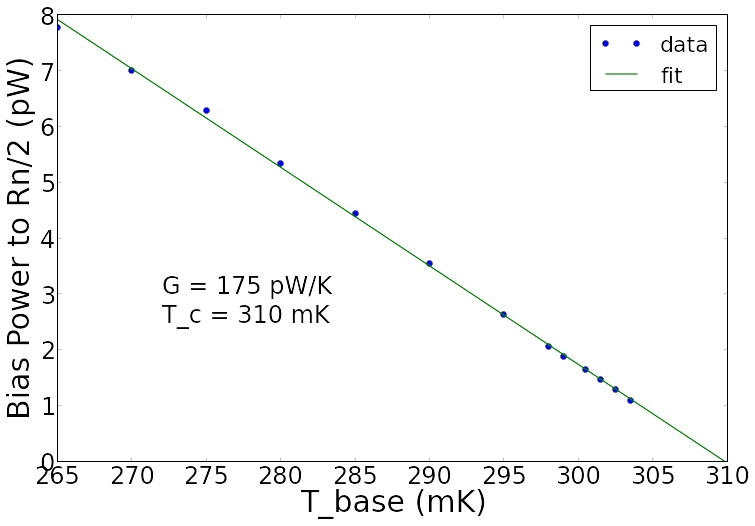

In [584]:
#basedir = '/Users/jlazear/data/TES/'

Tbase_mids = np.array(Tbase_mids)
P_mids = np.array(P_mids)

fig, ax = subplots(figsize=(12, 8))
ax.plot(Tbase_mids*1.e3, P_mids, 'o', label='data')

(m, b), cov = np.polyfit(Tbase_mids, P_mids, 1, cov=True)

T0s = np.linspace(0.265, .310)
P0s = m*T0s + b
# ax.plot(Tbase_mids, m*Tbase_mids + b, label='fit', linewidth=1.5)
ax.plot(T0s*1.e3, P0s, label='fit', linewidth=1.5)
legend(loc='upper right', fontsize=22)
ax.set_xlabel('T_base (mK)', fontsize=30)
ax.set_ylabel('Bias Power to Rn/2 (pW)', fontsize=30)
ax.tick_params(axis='both', labelsize=24)

ax.set_xlim(.265*1.e3, .310*1.e3)
ax.set_ylim(0, 8)

G = -m  # pW/K, since P_mids is in pW
sG = cov[0, 0]
sb = cov[1, 1]
Tc = b/G  # K, since b is in pW
sTc = Tc*np.sqrt((sb/b)**2 + (sG/G)**2)

lblstr = "G = {0} pW/K\nT_c = {1} mK".format(int(round(G/5)*5), int(round(Tc*1.e3/5)*5))
ax.annotate(lblstr, [.272*1.e3, 2.5], fontsize=24)
# ax.set_title('SPTD\n' + lblstr)
print lblstr
print "G = {0} +- {1} pW/K".format(G, sG)
print "Tc = {0} +- {1} mK".format(Tc*1.e3, sTc*1.e3)

fig.savefig(basedir + 'G_Tc3.png', dpi=300, bbox_inches='tight')

In [47]:
#basedir = '/Users/jlazear/data/TES/'

Tbase_mids = np.array(Tbase_mids)
P_mids = np.array(P_mids)

fig, ax = subplots(figsize=(12, 8))
ax.plot(Tbase_mids*1.e3, P_mids, 'o', label='data')

(m, b), cov = np.polyfit(Tbase_mids, P_mids, 1, cov=True)

T0s = np.linspace(0.265, .310)
P0s = m*T0s + b
# ax.plot(Tbase_mids, m*Tbase_mids + b, label='fit', linewidth=1.5)
ax.plot(T0s*1.e3, P0s, label='fit', linewidth=1.5)
legend(loc='upper right', fontsize=22)
ax.set_xlabel('T_base (mK)', fontsize=30)
ax.set_ylabel('Bias Power to Rn/2 (pW)', fontsize=30)
ax.tick_params(axis='both', labelsize=24)

ax.set_xlim(.265*1.e3, .310*1.e3)
ax.set_ylim(0, 8)

G = -m  # pW/K, since P_mids is in pW
sG = cov[0, 0]
sb = cov[1, 1]
Tc = b/G  # K, since b is in pW
sTc = Tc*np.sqrt((sb/b)**2 + (sG/G)**2)

lblstr = "G = {0} pW/K\nT_c = {1} mK".format(int(round(G/5)*5), int(round(Tc*1.e3/5)*5))
ax.annotate(lblstr, [.272*1.e3, 2.5], fontsize=24)
# ax.set_title('SPTD\n' + lblstr)
print lblstr
print "G = {0} +- {1} pW/K".format(G, sG)
print "Tc = {0} +- {1} mK".format(Tc*1.e3, sTc*1.e3)

#fig.savefig(basedir + 'G_Tc3.png', dpi=300, bbox_inches='tight')

NameError: name 'Tbase_mids' is not defined

In [498]:
from scipy.stats import chi2

dPdT = G
dT = 1e-3
sP_mids = dPdT * dT
f = lambda T: m*T + b

def chi2value(xs, ys, sys, fitfunc):
    eys = fitfunc(xs)
    return np.sum(((ys - eys)/sys)**2)

x2linear = chi2value(Tbase_mids, P_mids, sP_mids, f)
dof = len(Tbase_mids) - 1
print "x2/({0} - 1) = ".format(dof), x2linear/(dof - 1)
print chi2.cdf(x2linear, dof - 1)

x2/(12 - 1) =  0.157433103325
0.000761329019612


In [499]:
dx2 = x2linear - x2power
print "delta x2 = ", dx2
print chi2.cdf(dx2, 1)

delta x2 =  1.00048788023
0.682807516079


In [405]:
sigma_m, sigma_b = cov[0, 0]/m, cov[1, 1]/b
print "fractional sigma_m = ", sigma_m
print "fractional sigma_b = ", sigma_b

fractional sigma_m =  -0.015997839994
fractional sigma_b =  0.00433904891304


G = -55 pW/K
T_c = -390 mK


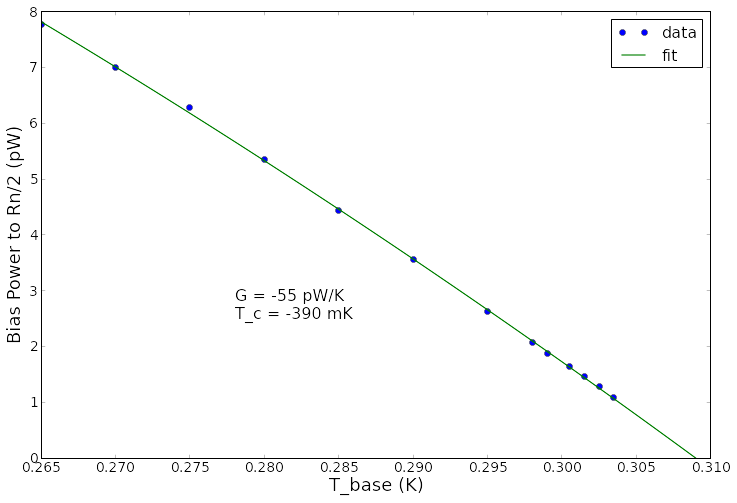

In [406]:
#basedir = '/Users/jlazear/data/TES/'

Tbase_mids = np.array(Tbase_mids)
P_mids = np.array(P_mids)

fig, ax = subplots(figsize=(12, 8))
ax.plot(Tbase_mids, P_mids, 'o', label='data')

(m2, m, b), cov = np.polyfit(Tbase_mids, P_mids, 2, cov=True)

T0s = np.linspace(0.265, .310)
P0s = m2*T0s**2 + m*T0s + b
# ax.plot(Tbase_mids, m*Tbase_mids + b, label='fit', linewidth=1.5)
ax.plot(T0s, P0s, label='fit', linewidth=1.5)
legend(loc='upper right', fontsize=16)
ax.set_xlabel('T_base (K)', fontsize=18)
ax.set_ylabel('Bias Power to Rn/2 (pW)', fontsize=18)
ax.tick_params(axis='both', labelsize=14)

ax.set_xlim(.265, .310)
ax.set_ylim(0, 8)

G = -m  # pW/K, since P_mids is in pW
Tc = b/G  # K, since b is in pW

lblstr = "G = {0} pW/K\nT_c = {1} mK".format(int(round(G/5)*5), int(round(Tc*1.e3/5)*5))
ax.annotate(lblstr, [.278, 2.5], fontsize=16)
# ax.set_title('SPTD\n' + lblstr)
print lblstr

#fig.savefig(basedir + 'G_Tc.png', dpi=300, bbox_inches='tight')

In [407]:
sigma_m2, sigma_m, sigma_b = cov[0, 0]/m2, cov[1, 1]/m, cov[2, 2]/b
print "fractional sigma_m2 = ", sigma_m2
print "fractional sigma_m = ", sigma_m
print "fractional sigma_b = ", sigma_b

fractional sigma_m2 =  -34.2527546519
fractional sigma_m =  81.9631423707
fractional sigma_b =  4.25562891928


# Misc

In [312]:
f = fs[0]
mp = modpwrs[0]
np.array(zip(f, mp))

array([[  1.94756151e-02,   6.05045246e-15],
       [  3.79705080e-02,   1.80799904e-15],
       [  5.76326280e-02,   7.23240298e-16],
       [  7.71833873e-02,   5.35982249e-16],
       [  9.50899989e-02,   4.23827171e-16],
       [  1.12363083e-01,   3.49974828e-16],
       [  1.32773821e-01,   3.33081224e-16],
       [  1.50480096e-01,   2.95341973e-16],
       [  1.70547620e-01,   4.00606885e-16],
       [  1.93291283e-01,   3.89834615e-16],
       [  2.10114813e-01,   4.97840935e-16],
       [  2.28402617e-01,   5.65756500e-16],
       [  2.48282139e-01,   4.75166779e-16],
       [  2.69891919e-01,   5.54616707e-16],
       [  2.81392218e-01,   4.80412308e-16],
       [  3.05883806e-01,   7.53707583e-16],
       [  3.18917747e-01,   4.61731566e-16],
       [  3.46675452e-01,   9.79983520e-16],
       [  3.61447556e-01,   8.01066284e-16],
       [  3.76849110e-01,   1.09411010e-15],
       [  3.92906936e-01,   1.11960198e-15],
       [  4.27104452e-01,   1.18757917e-15],
       [  

In [313]:
for i in range(len(fnames)):
    fname = fnames[i]
    f = fs[i]
    mp = modpwrs[i]
    newfname = os.path.splitext(fname)[0] + '.modpwrspec'
    print "Saving to {0}".format(newfname)
    np.savetxt(newfname, np.array(zip(f, mp)), header='frequency(Hz) power_spectral_density(W/rtHz)')

Saving to /Users/jlazear/data/TES/20140318_Ch1-TES_recycled_DETB-.400_transition-state_165.0mK_SHINY-shell-grounded_little-bat-floating_i-pos300:2^10.modpwrspec
Saving to /Users/jlazear/data/TES/20140318_Ch1-TES_recycled_DETB-.425_transition-state_165.0mK_SHINY-shell-grounded_little-bat-floating_i-pos300:2^10.modpwrspec
Saving to /Users/jlazear/data/TES/20140318_Ch1-TES_recycled_DETB-.450_transition-state_165.0mK_SHINY-shell-grounded_little-bat-floating_i-pos300:2^10.modpwrspec
Saving to /Users/jlazear/data/TES/20140318_Ch1-TES_recycled_DETB-.475_transition-state_165.0mK_SHINY-shell-grounded_little-bat-floating_i-pos300:2^10.modpwrspec
Saving to /Users/jlazear/data/TES/20140318_Ch1-TES_recycled_DETB-.500_transition-state_165.0mK_SHINY-shell-grounded_little-bat-floating_i-pos300:2^10.modpwrspec
Saving to /Users/jlazear/data/TES/20140318_Ch1-TES_recycled_DETB-.525_transition-state_165.0mK_SHINY-shell-grounded_little-bat-floating_i-pos300:2^10.modpwrspec
Saving to /Users/jlazear/data/TES/

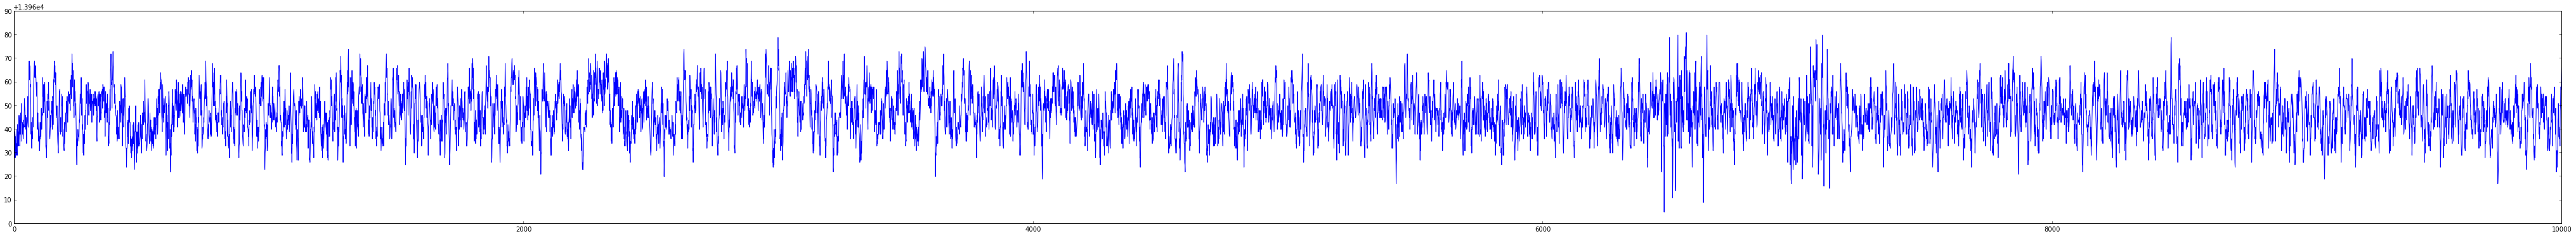

In [180]:
psrdr = PSRDR(list(fnamestxt)[1] + '.txt').init_data()
fig, ax = subplots(figsize=(72, 6))
ax.plot(psrdr[10000:20000])